In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import auc, roc_curve,confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
sns.set_theme(style="darkgrid")

In [2]:
data = pd.read_csv("fraude_data.csv")

#### La forme de l'ensemble de données

In [3]:
data.shape

(192500, 12)

On peut voir que les données comprennent des enregistrements et pour chaque enregistrement, nous avons les attributs de la transaction.

Nous avons un grand nombre d'enregistrement soit:
- 192500 lignes et 12 colonnes

**description des variale**O
  
- step : étape (l'unité de temps) une étape correspond à 1 heure de temps et nous avons un total de 744 étapes.
- type : le type de transaction
- amount : le montant
- nameOrigine: l'origine de la transaction
- nameDest: la destination de la transaction
-oldbalanceOrg: anciern solde d'origne
- newdbalanceOrg: nouveau solde d'origine
- oldbalancedest: ancien solde de destination
- newdbalancedest: nouveau solde de destinaion
- isFraud: désigne le type de transaction
- isFlaggedFraude: signale une transaction comme frauduleuse  ou pas 

  



In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192500 entries, 0 to 192499
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   index           192500 non-null  int64  
 1   step            192500 non-null  int64  
 2   type            192500 non-null  object 
 3   amount          192500 non-null  float64
 4   nameOrig        192500 non-null  object 
 5   oldbalanceOrg   192500 non-null  float64
 6   newbalanceOrig  192500 non-null  float64
 7   nameDest        192500 non-null  object 
 8   oldbalanceDest  192500 non-null  float64
 9   newbalanceDest  192500 non-null  float64
 10  isFraud         192500 non-null  int64  
 11  isFlaggedFraud  192500 non-null  int64  
dtypes: float64(5), int64(4), object(3)
memory usage: 17.6+ MB


On voit que nous avons des variables quantitatives continues, discrètes et les variables de type Object

**Vérifions la présence des valeurs manquantes**

In [5]:
data.isnull().sum()

index             0
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Nous disposons d'un ensemble de données propre avec absolument, aucune valeur manquante

#### Analyse descriptive

In [6]:

data.describe()

,index,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,1.925000e+05,192500.000000,1.925000e+05,1.925000e+05,1.925000e+05,1.925000e+05,1.925000e+05,192500.000000,192500.000000
mean,3.217914e+06,247.825377,2.261676e+05,8.616604e+05,8.270867e+05,1.084274e+06,1.230771e+06,0.038961,0.000083
std,1.861619e+06,147.685363,7.720697e+05,2.912266e+06,2.887263e+06,3.297716e+06,3.575349e+06,0.193503,0.009116
min,2.000000e+00,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.593112e+06,156.000000,1.401661e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,3.216306e+06,249.000000,8.060089e+04,1.696019e+04,0.000000e+00,1.144710e+05,2.091728e+05,0.000000,0.000000
75%,4.835272e+06,347.000000,2.188217e+05,1.336372e+05,1.290969e+05,9.127214e+05,1.115385e+06,0.000000,0.000000
max,6.362619e+06,743.000000,6.988673e+07,5.958504e+07,4.958504e+07,2.511150e+08,2.506381e+08,1.000000,1.000000


#### Analyse univarié

In [7]:
data['nameDest'].nunique()
# nameDest contient l'identifiant de la personne qui a reçu le montant de la transaction

168929

Nous avons un total de 168929 noms à peu près uniques

In [8]:
data['nameOrig'].nunique()
# nameOrig contient l'identifiant de la personne qui a transféré le montant de la transaction

192494

On constate égalément que la variable **nameOrig** a un grand nombre de valeur unique

les enregistrement qui ont un grand nombre de valeurs unique n'ont pas beaucoup de pouvoir prédictif

In [9]:
# suppression de trois colonnes
data= data.drop(labels = ['index','nameOrig', 'nameDest'], axis=1)

data.sample(5)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
172743,275,PAYMENT,3753.80,10801.51,7047.71,0.00,0.00,0,0
66725,307,CASH_OUT,129505.90,18451.00,0.00,753484.87,882990.77,0,0
56279,232,CASH_OUT,1733.30,0.00,0.00,160721.27,162454.57,0,0
104519,404,PAYMENT,18659.46,99718.98,81059.52,0.00,0.00,0,0
107532,353,CASH_IN,222769.52,134596.00,357365.52,323490.51,100720.99,0,0


**Déterminons le nombre de transaction frauduleuse**

**NB**

- 0 : Non frauduleux
- 1 : Frauduleux

In [10]:
data['isFraud'].value_counts()

isFraud
0    185000
1      7500
Name: count, dtype: int64

Le résultat nous montre que nous disposons d'un ensemble de données très asymétrique. Sur environ   185.000 enregistrements seuls **7.500** ont été étiquetés comme **frauduleux**

#### Visualisation

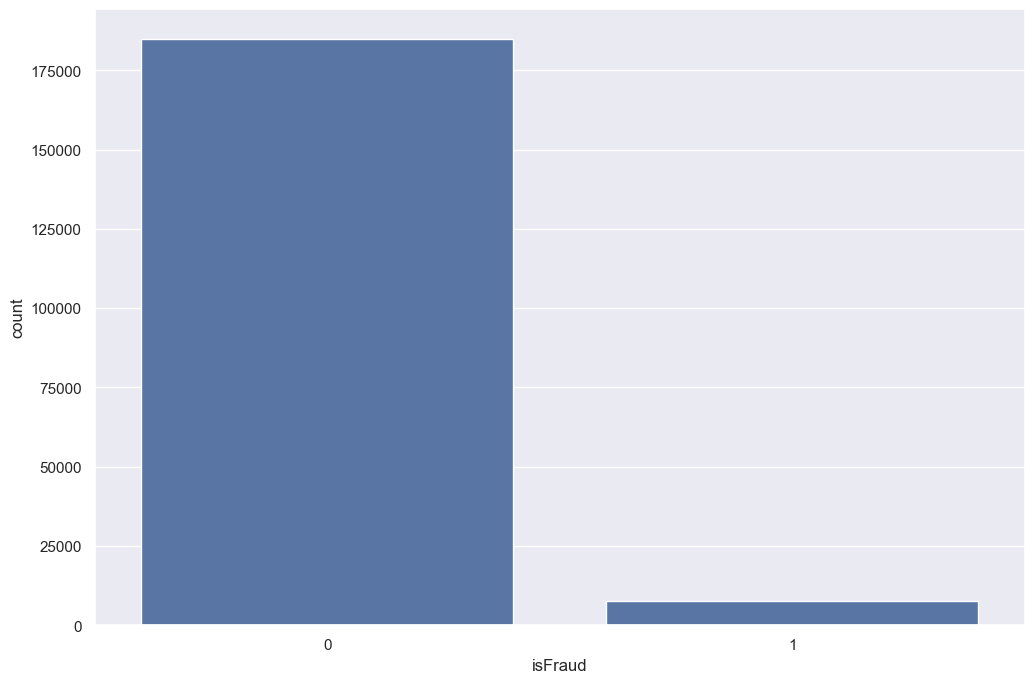

In [11]:
plt.figure(figsize = (12, 8))

sns.countplot(x='isFraud', data = data);

On observe que très peu de transaction sont réelement frauduleuse et cela est également vrai dans le monde réel, parmi le grand nombre de transaction qui ont lieu dans les institutions financières, très peu sont en fait des **fraudes**

**Examinons le nombre d'enregistrement signalés comme frauduleux**

In [12]:
data['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    192484
1        16
Name: count, dtype: int64

<Figure size 1000x600 with 0 Axes>

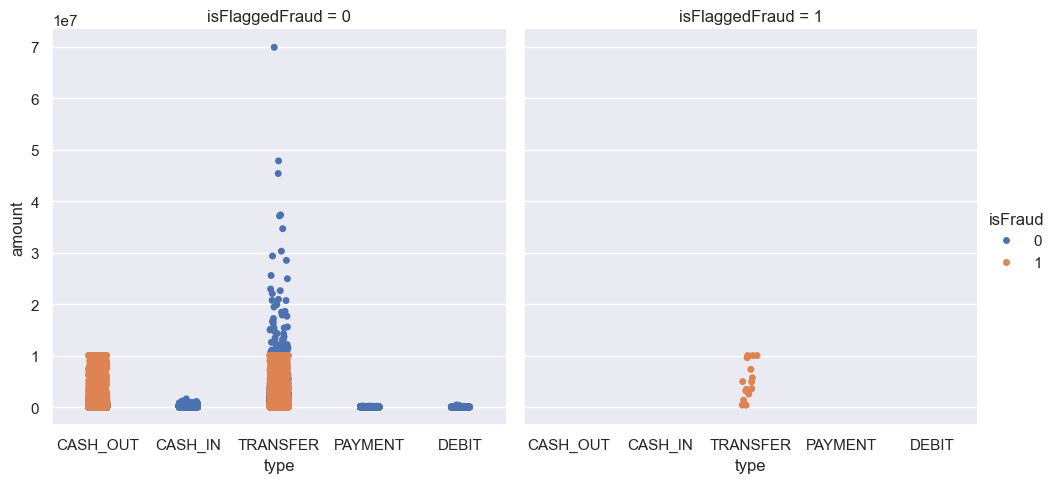

In [13]:
plt.figure(figsize = (10, 6))

sns.catplot(x = 'type', y = 'amount', estimator = sum,
            hue = 'isFraud' , col = 'isFlaggedFraud',
            data = data);

De la visualisation nous observons des transactions qui n'ont pas été signalées comme une fraude d'une part et d'un notre coté des transaction qui ont été signalées comme frauduleuse et on peut voir que toutes les transactions frauduleuses sont soit des transactions de type **CASH_OUT** ou **TRANSFER** et seulement **16 transactions** ont été signalées comme **frauduleuses** cela nous indique que ce marquage **heuristique** qui était déjà utilisé n'a pas beaucoup de pouvoir prédictif
**isFlagged** n'est probablement pas une colonne que nous allons utiliser comme prédicteur

<Axes: xlabel='step', ylabel='Count'>

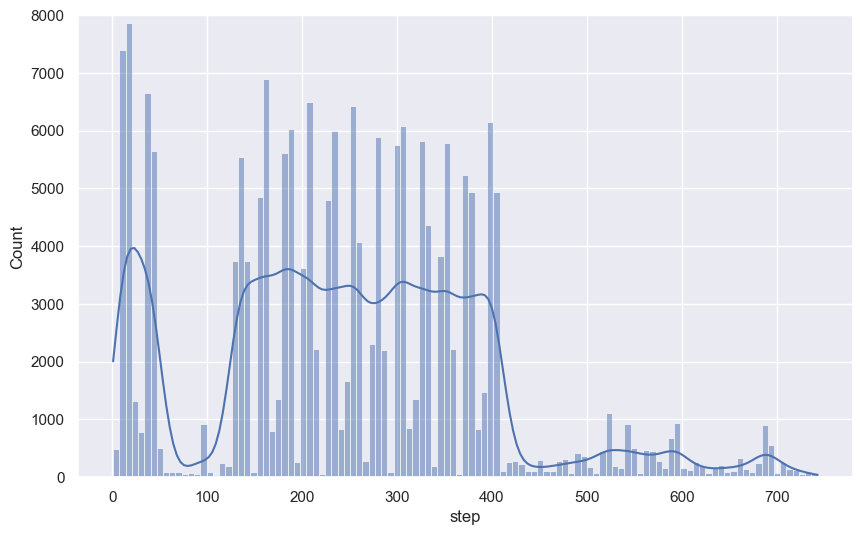

In [14]:
plt.figure(figsize =(10,6))
plt.ylim([0, 8000])
sns.histplot(data['step'], kde=True)

- une étape -> 1H
- une journée -> 24 étape
donc un total 744 étapes corresrpond à 30 jours

De la visualisation, on bserve un grand nombre de transaction en début de mois, puis un bon nombre en milieu de mois mais peu de transaction en fin de mois


**exprimons la variable step  en termes de 24H** pour une analyse plus approfondue

In [15]:
data['step'] =data['step']  %24
data.sample(5)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
186256,21,CASH_OUT,461442.52,461442.52,0.00,11029.55,472472.07,1,0
113216,18,PAYMENT,181.29,13284.13,13102.84,0.00,0.00,0,0
50784,18,CASH_IN,64668.81,1298036.55,1362705.37,1206801.53,1142132.72,0,0
166863,10,CASH_IN,90860.22,50307.00,141167.22,428000.24,337140.02,0,0
192028,0,CASH_OUT,10000000.00,10000000.00,0.00,841522.24,10841522.24,1,0


C:\Users\hawad\AppData\Local\Temp\ipykernel_13748\1105282635.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x = 'step', y = 'amount', hue = 'type', ci = None,


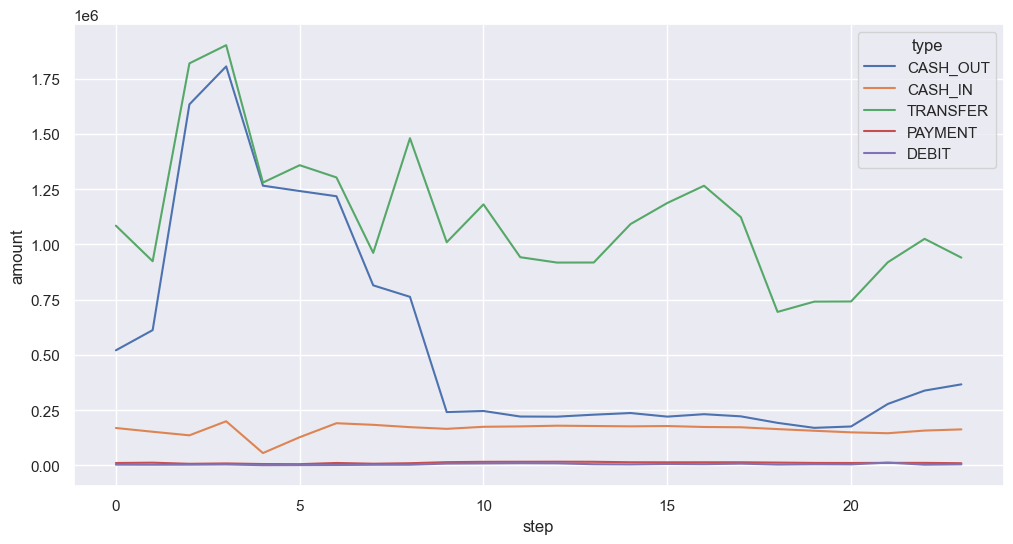

In [16]:
plt.figure(figsize = (12, 6))

sns.lineplot(x = 'step', y = 'amount', hue = 'type', ci = None,
             estimator = 'mean', data = data);

Ce graphique linéaire suit le montat moyen de la transaction à différentes périodes de la journée et les différentes lignes correspondent aux différents types de transaction.

Toutes les transactions frauduleuses de
cet ensemble de données sont soit des transactions **CASH_OUT**, soit des transactions **TRANSFER** et on peut voir que le montant de ce type de transactions croit très tôt dans la journée, ces transactions se produisent pour des montants moyens très élevés dans les premières heures de (0 à 4 heures) très tôt le matin

vérifions si les transactions frauduleuses se produisent au petit matin.

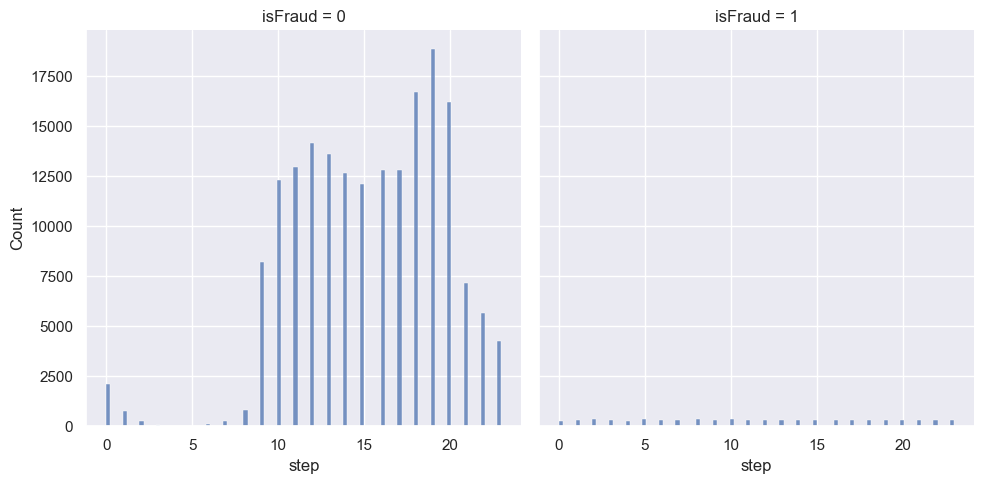

In [17]:
sns.displot(data = data, x = 'step', col = 'isFraud');

On peut constater que les transactions frauduleuses se produisent uniformément tout au long de la journée, mais que la plupart des transactions authentiques se déroulent de 9 heures à la fin de la journée. Ainsi, les transactions en début de journée (0 à 9) ont une probabilité plus élevée d'être frauduleuses.

<Axes: xlabel='type', ylabel='count'>

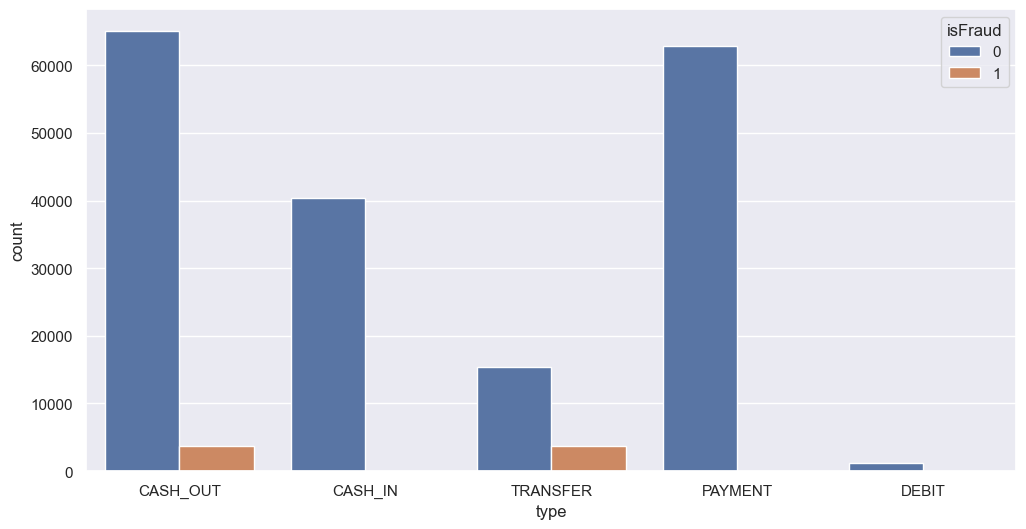

In [18]:
plt.figure(figsize = (12, 6))

sns.countplot(x = 'type', hue = 'isFraud', data = data)

Les transactions frauduleuses se produisent uniquement dans les transactions de type « CASH OUT » et « TRANSFER ». On peut également constater que le nombre de retraits et de transferts pour les transactions frauduleuses est presque égal.

Les valeurs de transaction pour chaque type sont affichées. Le type TRANSFERT a les valeurs les plus élevées et le type DEBIT est le plus bas.

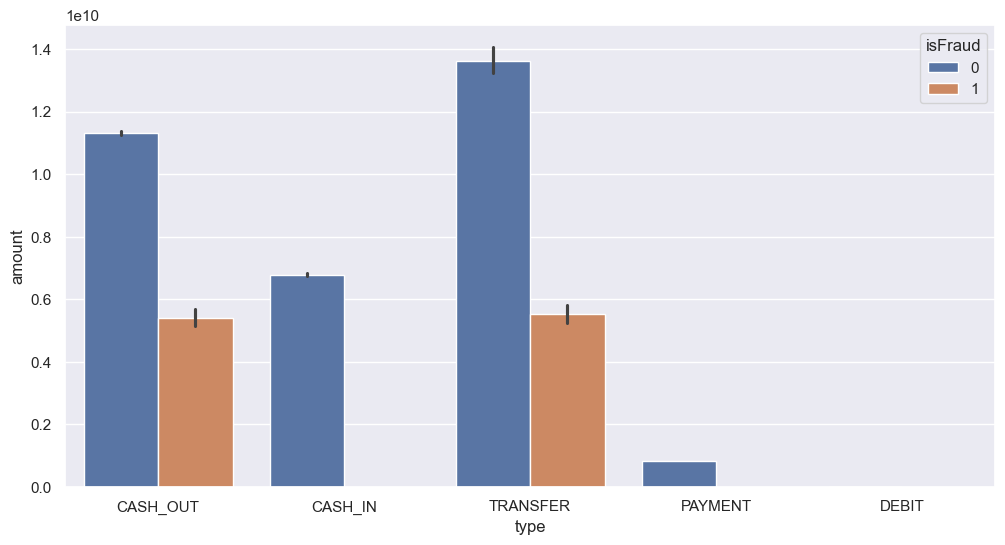

In [19]:
plt.figure(figsize = (12, 6))

sns.barplot(x = 'type', y = 'amount', estimator = sum, hue = 'isFraud', data = data);

On peut voir que le montant (transaction) des transactions frauduleuses est limité à 1 000 000.

In [20]:
data =data.loc[(data.type == 'TRANSFER') |   (data.type == 'CASH_OUT')]
data.shape

(87998, 9)

Nous convertissons la variable 'type' sous forme numérique en utilisant la méthode 'get_dummies' de pandas

In [21]:
data = pd.concat([data, pd.get_dummies(data['type'],
                                             prefix = 'type', drop_first = True)],
                              axis = 1)

data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_TRANSFER
0,11,CASH_OUT,427818.23,198219.0,0.00,0.00,427818.23,0,0,False
2,20,CASH_OUT,80828.54,0.0,0.00,5149991.49,5230820.04,0,0,False
3,20,TRANSFER,106069.89,301258.0,195188.11,263816.83,369886.72,0,0,True
6,18,CASH_OUT,402832.90,11665.0,0.00,28550.98,431383.87,0,0,False
12,22,CASH_OUT,34643.49,0.0,0.00,346081.41,380724.90,0,0,False


Type_TRANSFER aura une valeur **0** correspondant aux transactions **CASH_OUT** et la valeur **1** correspondant aux transactions **TRANSFER**

In [22]:
data = data.drop(labels = ['type','isFlaggedFraud'], axis = 1)
data.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_TRANSFER
0,11,427818.23,198219.0,0.00,0.00,427818.23,0,False
2,20,80828.54,0.0,0.00,5149991.49,5230820.04,0,False
3,20,106069.89,301258.0,195188.11,263816.83,369886.72,0,True
6,18,402832.90,11665.0,0.00,28550.98,431383.87,0,False
12,22,34643.49,0.0,0.00,346081.41,380724.90,0,False


In [23]:
data['isFraud'].value_counts()

isFraud
0    80498
1     7500
Name: count, dtype: int64

on peut voir que la classe est moins biaisé

Ici, nous avons créé deux nouvelles fonctionnalités basées sur les écarts de compte bancaire suite à une transaction de montant.

- La prémière colonne conçue suit l'écart dans le compte de solde d'origine.Si on ajoute le montant de la transaction au nouveau solde puis soustraire l'ancien solde, on verifie le resultat

- La deuxième colonne suit l'écart dans le compte de destination et on fait l'opération inverse

In [24]:
data['origBalanceDiscrepancy'] = \
   data.newbalanceOrig + data.amount -data.oldbalanceOrg

data['destBalanceDiscrepancy'] = \
    data.oldbalanceDest + data.amount - data.newbalanceDest

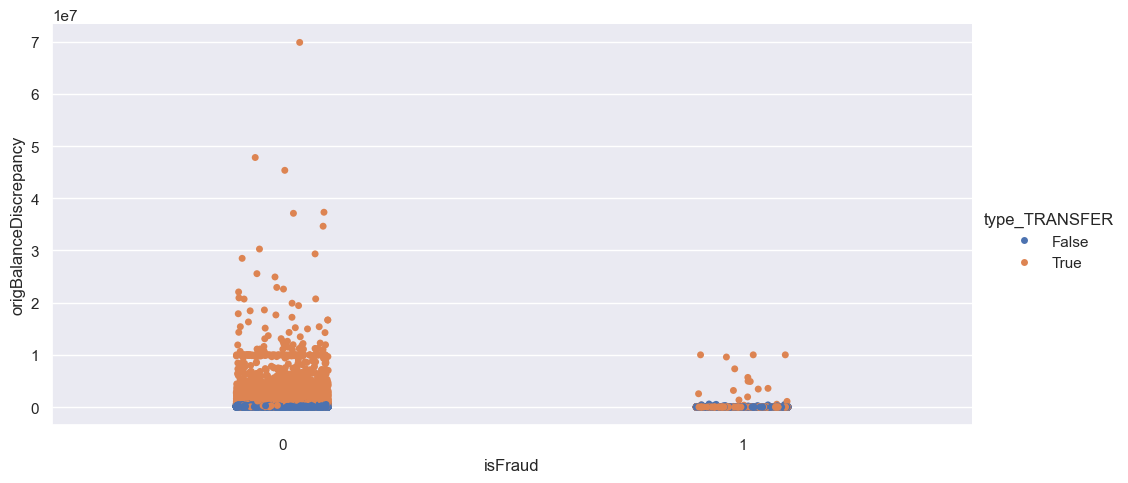

In [25]:
sns.catplot(x = 'isFraud', y = 'origBalanceDiscrepancy', estimator = sum,hue = 'type_TRANSFER', data = data, aspect = 2)

Sur la base du montant de la transaction, on ne voit pas de modèle clair, il existe des transactions frauduleuses et non frauduleuses, qui semblent toutes deux présenter une certaine divergence dans le solde du compte d'origine. Cette fonctionnalité ne semble ajouter aucun modèle intéressant.

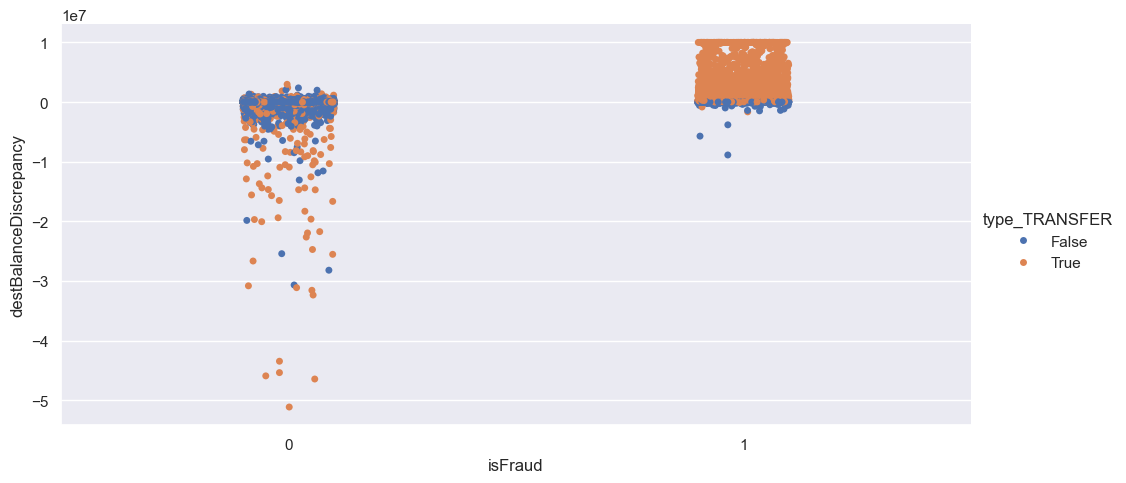

In [26]:
 sns.catplot(x = 'isFraud', y = 'destBalanceDiscrepancy', estimator = sum,
hue = 'type_TRANSFER' , data =data, aspect = 2)

Dans ce tracé nous pouvons voir que l'écart dans le compte de destination est très élevé pour les transactions frauduleuses. Pour les transactions non frauduleuses, l'écart est beaucoup plus faible dans l'ensemble, il y'a donc une tendance claire dans ce cas

In [27]:
data.to_csv('preprocessed_transaction_data.csv', index=False)

In [28]:
data_finance= pd.read_csv('preprocessed_transaction_data.csv')
data_finance.tail(10)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_TRANSFER,origBalanceDiscrepancy,destBalanceDiscrepancy
87988,21,973805.75,973805.75,0.0,0.00,0.00,1,True,0.0,973805.75
87989,10,45077.10,45077.10,0.0,0.00,0.00,1,True,0.0,45077.10
87990,3,6351930.74,6351930.74,0.0,475618.00,6827548.75,1,False,0.0,-0.01
87991,9,348983.86,348983.86,0.0,0.00,0.00,1,True,0.0,348983.86
87992,18,40388.58,40388.58,0.0,0.00,0.00,1,True,0.0,40388.58
87993,20,19742.71,19742.71,0.0,2098671.68,2118414.39,1,False,0.0,0.00
87994,14,298365.86,298365.86,0.0,0.00,298365.86,1,False,0.0,0.00
87995,14,1468304.35,1468304.35,0.0,0.00,0.00,1,True,0.0,1468304.35
87996,2,2984434.36,2984434.36,0.0,5498919.48,8483353.84,1,False,0.0,0.00
87997,4,254719.63,254719.63,0.0,0.00,0.00,1,True,0.0,254719.63


La variable cible est **isFraude** et nous essaierons de prédire à partir de cette variable si une transaction particulière est frauduleuse.

Configrons les fonctionnalités et la cible de notre modèle de classification



In [29]:
X = data_finance.drop(['isFraud'], axis = 1)

y = data_finance['isFraud']

#### Séparation de l'ensemble de données en des données d'entrainement et en données de test

Nous utiliserons **70%** des enregistrements dont nous disposons pour former notre modèle et **30%** pour evaluer notre modèle

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

X_train.shape, X_test.shape

((61598, 9), (26400, 9))

#### Construction des différents modèles de classification

- LogistiRegression
le modèle  **LogisticRegression** ajuste une courbe en **S** sur les données puis utilise cette courbe en **S** pour classer les points

In [31]:
logistic_clf = LogisticRegression()

logistic_clf.fit(X_train, y_train)


LogisticRegression()

#### Prédiction (LogisticRegression)

In [32]:
y_pred_logistic = logistic_clf.predict(X_test)

y_pred_logistic[:5]

array([0, 0, 0, 0, 0], dtype=int64)

#### Evaluation du modèle (LogisticRegression)

In [33]:
print('Logistic Regression\n')

print('Accuracy: ', accuracy_score(y_test, y_pred_logistic))
print('Precision: ', precision_score(y_test, y_pred_logistic))
print('Recall: ', recall_score(y_test, y_pred_logistic))

Logistic Regression

Accuracy:  0.9713636363636363
Precision:  0.9306987399770905
Recall:  0.7190265486725663


Ce résulat ici nous indique que notre modèle **LogisticRegression** a plutôt bien fonctionné sur notre ensemble de données (détection de fraude)
- L'accuracy est de **97%** bien que ce ne soit pas la bonne mesure ici, car il s'agit d'un ensemble de données très asymétrique.
- La précision est de **93%**, autrement dit, sur l'identification positive des transactions frauduleuses, 93% étaient correctes

- Le recall est d'environ **72%**, de toutes les transactions frauduleuses de l'ensemble de données,72% des transactions ont été correctement identifiées par le modèle

#### Naive Bayes
le modèle Naive bayes utilise des probablités conditionnelles pour déterminer si une transaction est frauduleuse ou non.

In [34]:
gnb_clf = GaussianNB()

gnb_clf.fit(X_train, y_train)

GaussianNB()

In [35]:
y_pred_gnb = gnb_clf.predict(X_test)

y_pred_gnb[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [36]:
print('Naive Bayes\n')

print('Accuracy: ', accuracy_score(y_test, y_pred_gnb))
print('Precision: ', precision_score(y_test, y_pred_gnb))
print('Recall: ', recall_score(y_test, y_pred_gnb))

Naive Bayes

Accuracy:  0.9371969696969698
Precision:  0.7099023709902371
Recall:  0.4504424778761062


 On peut voir que le modèle n'a pas de bonne performence
 - L'exactitude est toujours élevée mais la précision de ce modèle est d'environ **71%** et le rappel est assez faible, seulement 45% des transactions frauduleuses dans lensemble de données ont été identifiées par ce modèle.

#### Support Vector Machines

est un algorithme d’apprentissage automatique supervisé qui peut être utilisé pour les problèmes de classification ou de régression

In [37]:
svc_clf = SVC()

svc_clf.fit(X_train, y_train)

SVC()

In [38]:
y_pred_svc = svc_clf.predict(X_test)

y_pred_svc[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [39]:
print('Support Vector Classifier\n')

print('Accuracy: ', accuracy_score(y_test, y_pred_svc))
print('Precision: ', precision_score(y_test, y_pred_svc))
print('Recall: ', recall_score(y_test, y_pred_svc))

Support Vector Classifier

Accuracy:  0.963560606060606
Precision:  0.9828869047619048
Recall:  0.5845132743362832


Dans ce modèle la précision est extrêmement élevée à 98%, le rappel n'est pas aussi bon que le modèle de régression logistique à 58% mais meilleur que le modèle **Naive Bayes**

#### Random Forest
Le modèle Random Forest est un modèle d'ensemble, c'est à dire qu'il forme plusieurs modèles d'arbres de décision sous le capot,et la prédicton finale est agrégation des prédictions faites par ces multiples arbres de décision.

In [40]:
rf_clf = RandomForestClassifier()

rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [41]:
y_pred_rf = rf_clf.predict(X_test)

y_pred_rf[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [42]:
print('Random Forest\n')

print('Accuracy: ', accuracy_score(y_test, y_pred_rf))
print('Precision: ', precision_score(y_test, y_pred_rf))
print('Recall: ', recall_score(y_test, y_pred_rf))

Random Forest

Accuracy:  0.9995833333333334
Precision:  0.9995557529986673
Recall:  0.995575221238938


Les modèles d'ensemble ont tendance à faire mieux que les modèles ML autonomes,
les trois métrique calculées pour ce modèle sont tous à 99% ou plus. Il s'agit clairement d'un très bon modèle de détection de fraude pour cet ensemble de données/

#### Calcul d'autres metriques (ROC et AUC)

- ROC la courbe caractéristique de l'opérateur du récepteur
le ROC trace le taux de vrais positifs d'un modèle de classification par rapport au taux de faux positifs.

Pour tout modèle, nous voulons maximiser les vrais positifs et minimiser les faux positis.


- AUC l'aire sous la courbe, mesure la performance de notre modèle AUC, mesure la capacité de nos modèle de classification à distinguer ou différencier les classes.

#### Calculons le roc pour tous les modèles

In [43]:
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_pred_logistic)

AUC_logistic = auc(fpr_logistic, tpr_logistic)

print('AUC for Logistic Regression :', AUC_logistic)

AUC for Logistic Regression : 0.8570070605831763


In [44]:
fpr_gnb, tpr_gnb, _ = roc_curve(y_test, y_pred_gnb)

AUC_gnb = auc(fpr_gnb, tpr_gnb)

print('AUC for Naive Bayes :', AUC_gnb)

AUC for Naive Bayes : 0.7166048346298509


 On peut voir que le l'AUC pour le modèle Naive Bayes est plus bas seulement environ 0.71. Les metriques d'exactitude, de précison et de rappel ont également indiqué que le modèle Naive Bayes n'était pas aussi bon que le modèle de régression logistique

In [45]:
fpr_svc, tpr_svc, _ = roc_curve(y_test, y_pred_svc)

AUC_svc = auc(fpr_svc, tpr_svc)

print('AUC for Support Vector Classifier :', AUC_svc)

AUC for Support Vector Classifier : 0.7917802494299477


 Le modèle Support Vector Classifier a un AUC de 0.79. Mieux que Naive Bayes, mais pas aussi bon que la Régression logistique.

In [46]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

AUC_rf = auc(fpr_rf, tpr_rf)

print('AUC for Random Forest :', AUC_rf)

AUC for Random Forest : 0.9977668981091127


L'AUC de ce modèle est de 0.99, la meilleur métrique de tous les modèles que nous avons formés.

### Répresentation graphique du ROC pour chacun des modèles

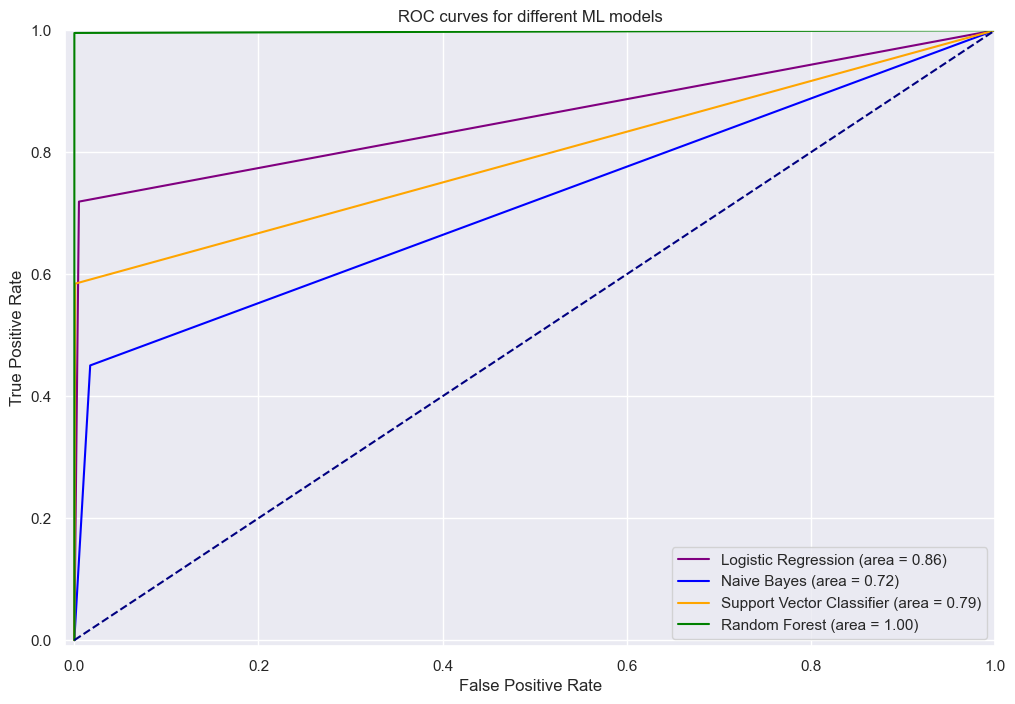

In [47]:
plt.figure(figsize=(12, 8))

plt.plot(fpr_logistic, tpr_logistic, color = 'purple',
         label = 'Logistic Regression (area = %0.2f)' % AUC_logistic)

plt.plot(fpr_gnb, tpr_gnb, color = 'blue',
         label = 'Naive Bayes (area = %0.2f)' % AUC_gnb)

plt.plot(fpr_svc, tpr_svc, color = 'orange',
         label = 'Support Vector Classifier (area = %0.2f)' % AUC_svc)

plt.plot(fpr_rf, tpr_rf, color = 'green',
         label = 'Random Forest (area = %0.2f)' % AUC_rf)

plt.plot([0, 1], [0, 1], color = 'navy', linestyle = '--')

plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curves for different ML models')
plt.legend(loc = 'lower right')

Le modèle Random Forest a le meilleur AUC, presque 1, maximisant le taux de vrai positif, minimisant le taux de faux positifs.

La ligne en pointillée ici est un ROC hypothétique pour un classifieur aléatoire. Si notre classifiacteur classe au hasard les transactions comme frauduleuses et non frauduleuses, le ROC du modèle de classification aléatoire ressemblera à la ligne en pointillée avec un angle de 45°. L'air sous la courbe ou l'AUC d'un classificateur aléatoire est de 0.5.

In [49]:
# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_rf)
print(conf_matrix )

[[24139     1]
 [   10  2250]]


In [51]:
# Affichage de la matrice de confusion

#plt.matshow(conf_matrix)
#plt.title('Matrice de Confusion')
#plt.ylabel('Véritable Label')
#plt.xlabel('Label Prédit')
#plt.show()